In [3]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv("merged_patient_data.csv")

In [5]:
# Reorder columns
df = df[['timestamp', 'event', 'BR', 'ECG', 'GSR', 'Patient_ID']]

In [6]:
# Round timestamp to integer
df['timestamp'] = df['timestamp'].astype(int)

In [7]:
# Compute the mean for numerical columns
numerical_avg = df.groupby('timestamp', as_index=False).mean(numeric_only=True)

In [8]:
# Compute mode for categorical columns
mode_values = df.groupby('timestamp')[['event', 'Patient_ID']].agg(lambda x: x.mode()[0])

In [9]:
# Merge the results
final_df = numerical_avg.merge(mode_values, on='timestamp')

In [10]:
print(final_df.head())

   timestamp         BR       ECG       GSR      event Patient_ID
0     112755  -7.653525 -0.026027  2.403242  INTERVALS       VP02
1     112756 -20.117188 -0.011926  2.636194  INTERVALS       VP02
2     112757 -44.542969 -0.022383  2.162604  INTERVALS       VP02
3     112758 -36.303953 -0.012908  1.740051  INTERVALS       VP02
4     112759  -4.527510 -0.020695  1.509757  INTERVALS       VP02


In [11]:
# You can also save using:
final_df.to_csv("Main_data.csv", index=False)

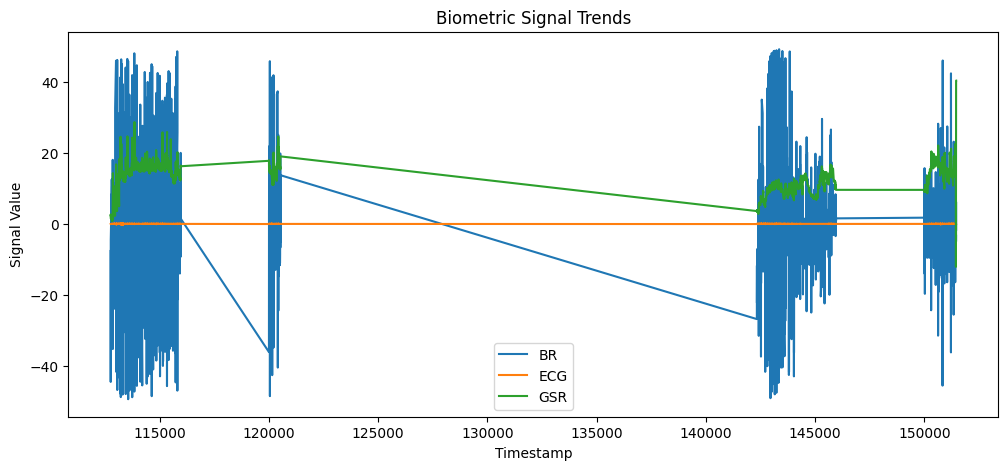

In [12]:
# Plot biometric signals
plt.figure(figsize=(12, 5))
plt.plot(final_df["timestamp"], final_df["BR"], label="BR")
plt.plot(final_df["timestamp"], final_df["ECG"], label="ECG")
plt.plot(final_df["timestamp"], final_df["GSR"], label="GSR")
plt.xlabel("Timestamp")
plt.ylabel("Signal Value")
plt.legend()
plt.title("Biometric Signal Trends")
plt.show()

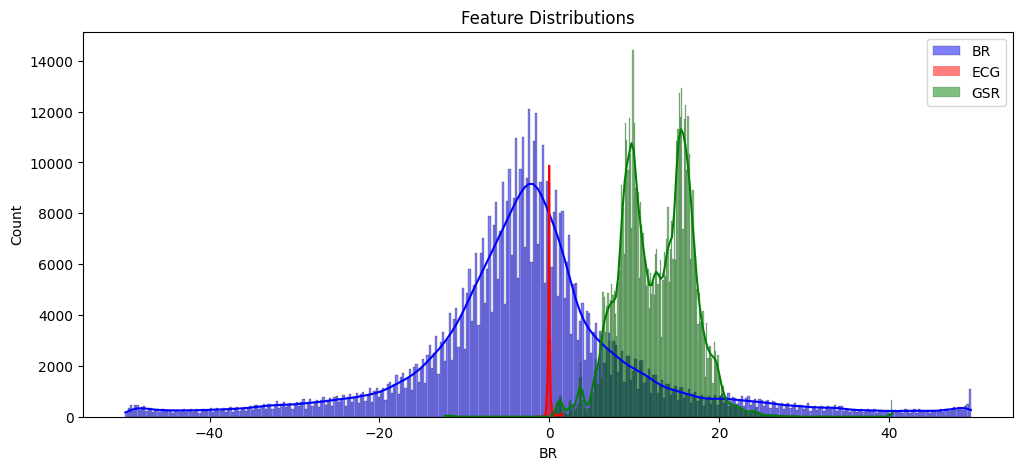

In [13]:
# 🔹 3️⃣ Data Visualization
plt.figure(figsize=(12, 5))
sns.histplot(df['BR'], kde=True, color='blue', label='BR')
sns.histplot(df['ECG'], kde=True, color='red', label='ECG')
sns.histplot(df['GSR'], kde=True, color='green', label='GSR')
plt.legend()
plt.title("Feature Distributions")
plt.show()

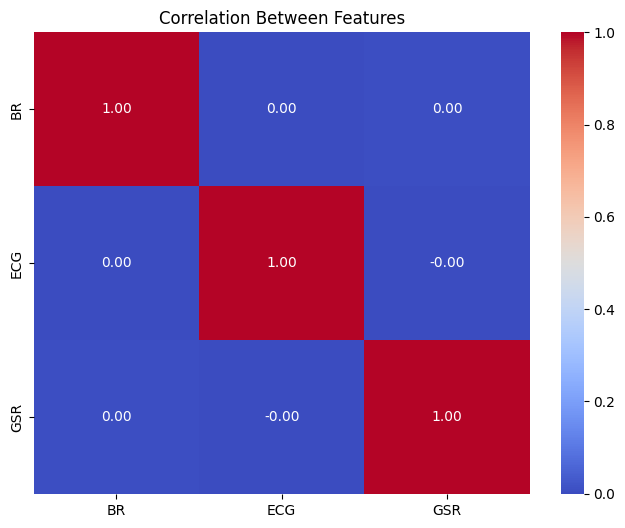

In [14]:
# Correlation Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[['BR', 'ECG', 'GSR']].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Features")
plt.show()

In [15]:
import pickle


In [16]:
# Normalize only the signal columns
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[['BR', 'ECG', 'GSR']])

In [17]:
def create_sequences(data, window_size=30):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

window_size = 30
X_seq = create_sequences(scaled_data, window_size)

In [18]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

timesteps = X_seq.shape[1]
features = X_seq.shape[2]

input_layer = Input(shape=(timesteps, features))
encoded = LSTM(64, activation='relu', return_sequences=False)(input_layer)
repeated = RepeatVector(timesteps)(encoded)
decoded = LSTM(64, activation='relu', return_sequences=True)(repeated)
decoded = TimeDistributed(Dense(features))(decoded)  # Map back to 3 features

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')


In [ ]:
history = autoencoder.fit(X_seq, X_seq,
                          epochs=10,
                          batch_size=64,
                          validation_split=0.1,
                          shuffle=True)


Epoch 1/10
9201/9201 ━━━━━━━━━━━━━━━━━━━━ 495s 51ms/step - loss: 0.2599 - val_loss: 0.0245
Epoch 2/10
9201/9201 ━━━━━━━━━━━━━━━━━━━━ 560s 61ms/step - loss: 0.0611 - val_loss: 0.0151
Epoch 3/10
9201/9201 ━━━━━━━━━━━━━━━━━━━━ 450s 49ms/step - loss: 0.0486 - val_loss: 0.0102
Epoch 4/10
9201/9201 ━━━━━━━━━━━━━━━━━━━━ 400s 43ms/step - loss: 0.0428 - val_loss: 0.0083
Epoch 5/10
9201/9201 ━━━━━━━━━━━━━━━━━━━━ 1117s 121ms/step - loss: 0.0390 - val_loss: 0.0089
Epoch 6/10
9201/9201 ━━━━━━━━━━━━━━━━━━━━ 762s 83ms/step - loss: 0.0370 - val_loss: 0.0081
Epoch 7/10
9201/9201 ━━━━━━━━━━━━━━━━━━━━ 750s 81ms/step - loss: 0.0355 - val_loss: 0.0056
Epoch 8/10
9201/9201 ━━━━━━━━━━━━━━━━━━━━ 711s 77ms/step - loss: 0.0339 - val_loss: 0.0053
Epoch 9/10
2099/9201 ━━━━━━━━━━━━━━━━━━━━ 8:34 72ms/step - loss: 0.0321

In [ ]:
X_pred = autoencoder.predict(X_seq)
mse = np.mean(np.mean((X_seq - X_pred) ** 2, axis=2), axis=1)

# Set threshold (e.g., 95th percentile)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold


In [ ]:
plt.figure(figsize=(14, 6))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label='Anomaly Threshold')
plt.title('LSTM Autoencoder Anomaly Detection')
plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Extend anomalies back to original DataFrame (with offset due to windowing)
df = df.iloc[window_size:].copy()
df['recon_error'] = mse
df['anomaly'] = anomalies.astype(int)

# Save results
df.to_csv("anomaly_detected.csv", index=False)
